主-双対近接分離法による画像復元
--
* 2016年08月： 小野峻佑， "明日から使える凸最適化～近接分離最適化を中心に～" 画像の認識・理解シンポジウム（MIRU2016） チュートリアル講演，アクトシティ濱松. https://sites.google.com/site/thunsukeono/japanese 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

パラメータ
---

In [2]:
lambda_ = 500
gamma1 = 0.003
gamma2 = 1 / (8 * gamma1)
maxIter = 1000
stopcri = 0.01
cmap = 'gray'

観測データの生成
---

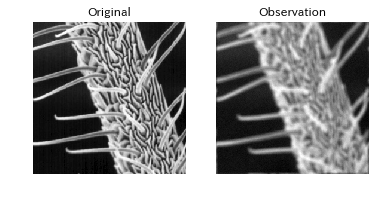

In [3]:
from skimage.io import imread
from scipy.fftpack import fft2, ifft2

u_org = imread("images/Culicoidae256.png", as_grey=True) / 255.
rows, cols = u_org.shape
N = rows * cols

# blur operator
psfsize = 7
psf = np.ones((psfsize, psfsize))
psf /= np.sum(psf)
blu = np.zeros(u_org.shape)
blu[:psf.shape[0], :psf.shape[1]] = psf
blu = np.roll(blu, -(psfsize//2), 0)
blu = np.roll(blu, -(psfsize//2), 1)
bluf = fft2(blu)
bluft = np.conj(bluf)
Phi = lambda z: ifft2(fft2(z) * bluf).real
Phit = lambda z: ifft2(fft2(z) * bluft).real

sigma = 2.5 / 255 # noise standard deviation
np.random.seed(42)
v = Phi(u_org) + sigma * np.random.randn(rows, cols)

fig, ax = plt.subplots(1, 2)
ax = ax.flatten()

ax[0].imshow(u_org, cmap=cmap)
ax[1].imshow(v, cmap=cmap)

ax[0].set_title('Original')
ax[1].set_title('Observation')

for a in ax:
    a.axis('off')
    
plt.savefig("data.png", dpi=220)

Primal Dual Splliting
---

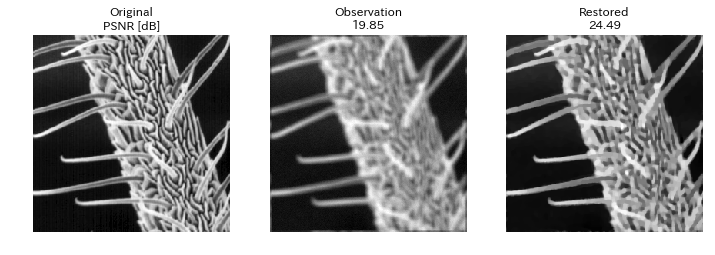

In [4]:
from skimage.measure import compare_psnr

#  difference operator
D = lambda z: np.dstack((np.roll(z, -1, 0) - z, np.roll(z, -1, 1) - z))
Dt = lambda z: np.r_[-z[:1, :, 0] + z[-1:, :, 0], -z[1:, :, 0] + z[:-1, :, 0]] + np.c_[-z[:, :1, 1] + z[:, -1:, 1], -z[:, 1:, 1] + z[:, :-1, 1]]

# variables
u = v
z = D(v)

for i in range(maxIter):
    upre = u.copy()
    
    # update u
    nablaF = lambda_ * Phit(Phi(u) - v)
    u = u - gamma1 * (nablaF + Dt(z))
    u[u > 1] = 1
    u[u < 0] = 0
    
    # update z
    z = z + gamma2 * D(2 * u - upre)
    temp = z / gamma2
    onemat = np.ones((rows, cols))
    thresh = 1 / np.sqrt(np.sum(temp ** 2, 2)) / gamma2
    thresh[thresh > 1] = 1
    coef = onemat - thresh
    temp = np.dstack((coef, coef)) * temp
    z = z - gamma2 * temp
    
    # stopping condition
    error = u - upre
    error = np.linalg.norm(error, ord=2)    
#     print(compare_psnr(u_org, u))
    if error < stopcri:
        break

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

ax[0].imshow(u_org, cmap=cmap)
ax[1].imshow(v, cmap=cmap)
ax[2].imshow(u, cmap=cmap)

ax[0].set_title('Original\nPSNR [dB]')
ax[1].set_title('Observation\n{:.2f}'.format(compare_psnr(u_org, v)))
ax[2].set_title('Restored\n{:.2f}'.format(compare_psnr(u_org, u)))

for a in ax:
    a.axis('off')
    
plt.savefig("result.png", dpi=220)